In [1]:
import pydpmd as dp
from pydpmd.plot import draw_particles_frame, create_animation, downsample, draw_circle
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import subprocess
from mode_resources import *
from system_building_resources import *
from matplotlib.colors import LogNorm
from scipy.special import j0

In [2]:
root = "/home/mmccraw/dev/data/11-15-25/jamming/disk/"
for fname in os.listdir(root):
    jam_data = dp.data.load(os.path.join(root, fname), location=['final', 'init'])
    # draw_particles_frame(None, plt.gca(), data, 20, True, 'particle', 'viridis', None)
    # plt.show()
    print(jam_data.packing_fraction[1])

0.8413476897478109
0.7782942952714909
0.8414420315623289
0.8412857816815381
0.8411670255661016
0.8412178066968924
0.8394107817411425
0.8303176879286769
0.8412857816219333
0.8412734709382061
0.8413740567564971


In [3]:
H_list, M_list, val_list, vec_list, non_rattler_id_list = get_dynamical_matrix_modes_for_disk(jam_data, 3, True)

100%|██████████| 50/50 [00:08<00:00,  5.74it/s]


In [203]:
np.argwhere([np.sum(v < 0) == 0 for v in val_list])

array([[21],
       [39]])

In [289]:
temp_target = 1e-7
delta_phi = -1e-3

In [290]:
new_data = []
for non_rattler_ids, val, vec, d in zip(non_rattler_id_list, val_list, vec_list, split_systems(jam_data)):
    _d = Disk()
    _d.allocate_particles(len(non_rattler_ids))
    _d.allocate_systems(1)
    _d.pos = d.pos[non_rattler_ids]
    _d.rad = d.rad[non_rattler_ids]
    _d.mass = d.mass[non_rattler_ids]
    _d.e_interaction = d.e_interaction
    _d.box_size = d.box_size

    d = 2

    # m = get_eimask(val)
    m = val > 1e-10
    v = np.sum(vec[:, m], axis=1)
    N = len(val) // d
    v = np.column_stack((v[:N], v[N:2*N]))

    _d.vel = v
    ke = np.sum(0.5 * np.sum(_d.vel ** 2, axis=-1))
    temp = ke * 2 / (d * (N - 1))
    _d.vel *= np.sqrt(temp_target / temp)

    _d.set_ids()
    _d.validate()
    new_data.append(_d)
new_data = join_systems(new_data)
new_data.calculate_packing_fraction()

In [3]:
path = os.path.join(root, 'test')

In [291]:
path = os.path.join(root, 'test')
# new_data.set_velocities(temp_target, np.random.randint(0, 1e9))
new_data.scale_to_packing_fraction(new_data.packing_fraction + delta_phi)
new_data.set_neighbor_method(NeighborMethod.Naive)
# new_data.set_neighbor_method(NeighborMethod.Cell)
set_standard_cell_list_parameters(new_data, 0.3)
new_data.save(path)

subprocess.run([
    os.path.join("/home/mmccraw/dev/dpmd/build/", "nve_disk_pbc_final"),
    path,
    path,
    str(1e5),
    str(1e2),
    str(1e-2)
], check=True)

Running for 100000 steps
Step 0
Step 10000
Step 20000
Step 30000
Step 40000
Step 50000
Step 60000
Step 70000
Step 80000
Step 90000
Done


CompletedProcess(args=['/home/mmccraw/dev/dpmd/build/nve_disk_pbc_final', '/home/mmccraw/dev/data/11-15-25/jamming/disk/test', '/home/mmccraw/dev/data/11-15-25/jamming/disk/test', '100000.0', '100.0', '0.01'], returncode=0)

In [4]:
dynamics_data = dp.data.load(path, location=['final', 'init'], load_trajectory=True)

In [ ]:
G = dynamics_data.trajectory.pos[:, :, 0] * dynamics_data.trajectory.vel[:, :, 1] * dynamics_data.mass

eh_msd = np.zeros((G.shape[0], G.shape[1]))
for i in tqdm(range(1, G.shape[0] - 1)):
    eh_msd[i] = np.mean((G[i:] - G[:-i]) ** 2, axis=0)

eh_msd = np.add.reduceat(eh_msd, dynamics_data.system_offset[:-1], axis=1) / dynamics_data.system_size

t = np.arange(eh_msd.shape[0])

100%|██████████| 998/998 [00:03<00:00, 287.20it/s]


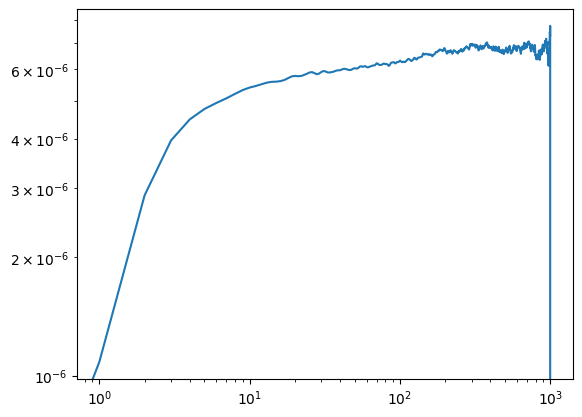

In [49]:
plt.plot(t, eh_msd[:, 9])
plt.xscale('log')
plt.yscale('log')


In [279]:
desired_frames = 100
steps_to_animate = downsample(dynamics_data, desired_frames)

output_path = "anim.gif"

# Create the animation using the downsampled steps
create_animation(
    update_func=draw_particles_frame,
    frames=steps_to_animate,
    filename=output_path,
    fps=15,
    bitrate=3000,
    data=dynamics_data,
    system_id=5,
    use_pbc=True,
    which='particle',
    cmap_name='grey',
    id_scale=1.1
)

Creating animation:   6%|▌         | 6/100 [00:00<00:01, 48.78it/s]

Saving animation to anim.gif...


Creating animation: 101it [00:04, 24.35it/s]                        

Animation saved successfully!


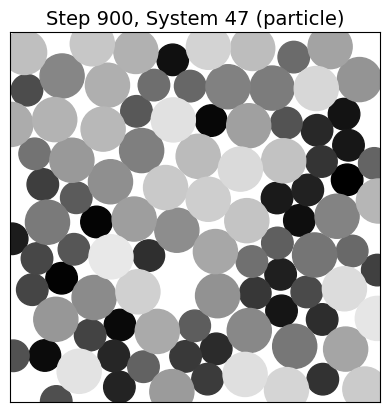

In [293]:
sid = 47
fid = 900
draw_particles_frame(fid, plt.gca(), dynamics_data, sid, True, 'particle', 'grey', 'trajectory', 1.1)
v = vec_list[sid].copy()

N = non_rattler_id_list[sid].size

# i = -1
# v_i = np.column_stack((v[:N, i], v[N:, i]))

# p = np.mod(data.pos[data.system_id == sid][non_rattler_id_list[sid]], data.box_size[sid])
# plt.quiver(p[:, 0], p[:, 1], v_i[:, 0], v_i[:, 1])

In [294]:
i0 = 0
P = dynamics_data.trajectory.pos[i0:]
k = (2 * np.pi / (2 * dynamics_data.rad))
C = np.add.reduceat(j0(k * np.linalg.norm(P - P[0], axis=-1)), dynamics_data.system_offset[:-1], axis=1) / dynamics_data.system_size
U = np.add.reduceat(np.linalg.norm(P - np.mean(P, axis=0), axis=-1), dynamics_data.system_offset[:-1], axis=1) / dynamics_data.system_size

np.int64(45)

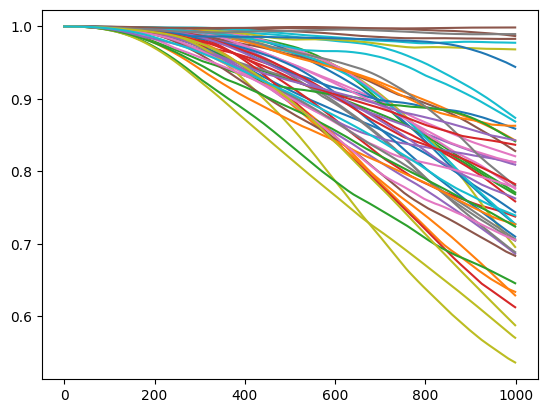

In [295]:
# plt.plot(C[:, sid])
# plt.plot(U[:, sid])
plt.plot(C)
# plt.plot(U)
np.argmax(np.abs(C[-1]))

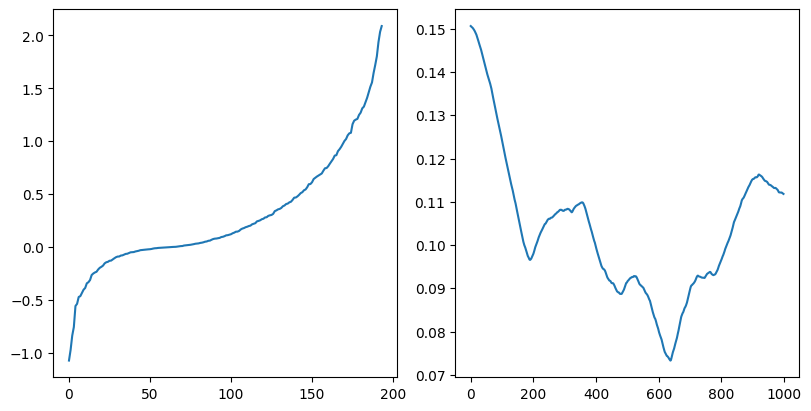

In [296]:
t0 = 0
tf = -1

P = dynamics_data.trajectory.pos[t0:tf, dynamics_data.system_id == sid]
V = dynamics_data.trajectory.vel[t0:tf, dynamics_data.system_id == sid]

U = P - np.mean(P, axis=0)
rmsd = np.sqrt(np.mean(np.linalg.norm(U, axis=-1), axis=1))

U = np.concatenate((U[..., 0], U[..., 1]), axis=1)
U = U.T @ U
V = np.concatenate((V[..., 0], V[..., 1]), axis=1)
V = V.T @ V
M = np.diag(np.concatenate([dynamics_data.mass[dynamics_data.system_id == sid] for i in range(2)]))

S_vals, Y_vecs, S_vecs = get_S_modes_from_matrices(M, U, V)

fig, ax = plt.subplots(1, 2, figsize=(8, 4), constrained_layout=True)
ax[0].plot(S_vals)
ax[1].plot(rmsd)


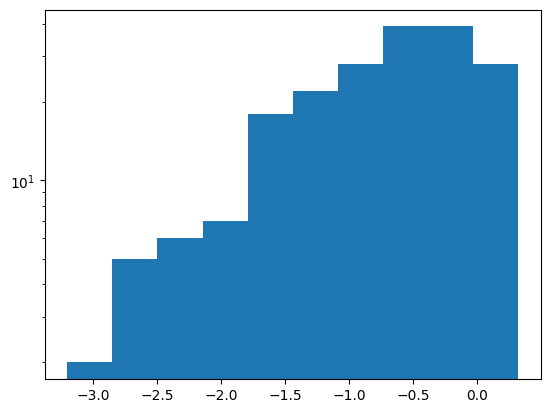

In [297]:
plt.hist(np.log10(np.abs(S_vals)))
plt.yscale('log')

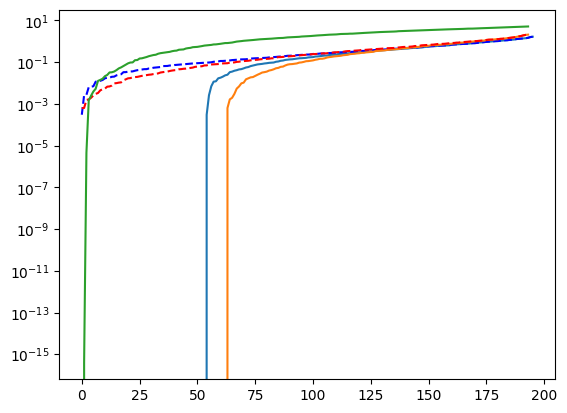

In [298]:
vals, vecs = np.linalg.eigh(V @ np.linalg.pinv(U))

plt.plot(vals)
plt.plot(np.sort(np.abs(vals)), color='b', ls='--')
plt.plot(S_vals)
plt.plot(np.sort(np.abs(S_vals)), color='r', ls='--')
plt.plot(val_list[sid][2:])
plt.yscale('log')